In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx
import numpy as np
from datetime import datetime, timedelta
import os

In [2]:
# get data from all_countries_2.csv
stamps = pd.read_csv('all_countries_2.csv')

C:\Users\Robin\AppData\Local\Temp\ipykernel_37728\721481993.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  stamps = pd.read_csv('all_countries_2.csv')


In [3]:
# get random GroupID (a folder in ./images/[country]/[GroupID]) where images exist in the folder except the watermarks folder (for all countries)
def get_random_group_id():
    emtpy = True
    while emtpy:
        country = stamps['Country'].sample().values[0]
        path = './images/' + country
        group_id = os.listdir(path)
        group_id = [x for x in group_id if x != 'watermarks']
        if len(group_id) > 0:
            # check if there are images in the folder
            if len(os.listdir(path + '/' + group_id[0])) > 0:
                emtpy = False
                
    return country, group_id[0]

country, group_id = get_random_group_id()

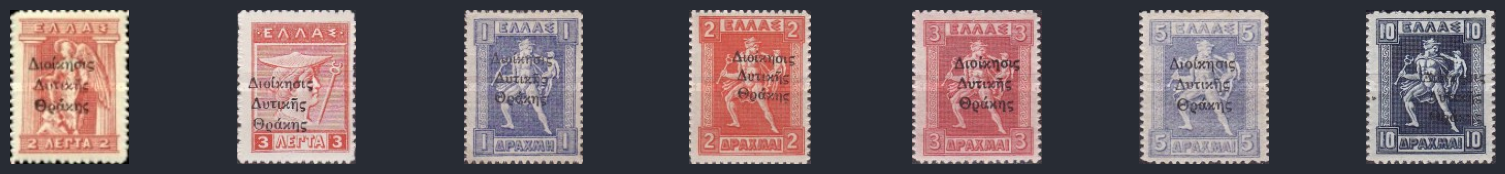

In [30]:
country, group_id = get_random_group_id()

# get all images in the folder (for a specific country and GroupID)
def get_images(country, group_id):
    path = './images/' + country + '/' + group_id
    images = os.listdir(path)
    images = [x for x in images if x != 'watermarks']
    return images

images = get_images(country, group_id)

# display all images in the folder (for a specific country and GroupID)
def display_images(images):
    # display images in raster
    fig, axs = plt.subplots(1, len(images), figsize=(20, 2))
    # make backgoound black
    fig.patch.set_facecolor('#282c34')
    for i, image in enumerate(images):
        img = Image.open('./images/' + country + '/' + group_id + '/' + image)
        axs[i].imshow(img)
        axs[i].axis('off')

display_images(images)

In [32]:
# get all entries in the csv file for a specific GroupID
def get_entries(group_id):
    group_id = int(group_id)
    entries = stamps[stamps['GroupID'] == group_id]
    return entries

entries = get_entries(group_id)

In [173]:
# get the setDescription of the first row
from numpy import NaN


def get_description(entries):
    return entries['SetDescription'].values[0]

# get YearSpan of the first row
def get_year_span(entries):
    return entries['YearSpan'].values[0]

# get Country of the first row
def get_country(entries):
    return entries['Country'].values[0]

# get the Continent of the first row
def get_continent(entries):
    return entries['Continent'].values[0]

# get the ParentCountries and remove [] and '
def get_parent_countries(entries):
    parent_countries = entries['ParentCountries'].values[0]
    parent_countries = parent_countries.replace('[', '').replace(']', '').replace("'", "")
    return parent_countries

# get Date of the first row
def get_date(entries):
    return entries['Date'].values[0]

# concat year_span and date
def get_year(entries):
    date = get_date(entries)
    year_span = get_year_span(entries)
    if year_span == 'nan':
        return date
    else:
        return date + ' (' + year_span + ')'

# get columns Watermark, Sheetsize, Design, Engraving, Performation, Unused, Used, LetterFDC and replace NaN with "-" of all rows
def get_columns(entries):
    # subset df entries to get the columns
    columns = entries[['Color', 'Value', 'Watermark', 'Sheetsize', 'Design', 'Engraving', 'Performation', 'Unused', 'Used', 'LetterFDC']]
    # replace NaN with "-"
    columns = columns.fillna('-')
    # if design and engraving applicable, just use the first 5 letter and then ...
    columns['Design'] = columns['Design'].apply(lambda x: x[:5] + '...' if len(x) > 5 else x)
    columns['Engraving'] = columns['Engraving'].apply(lambda x: x[:5] + '...' if len(x) > 5 else x)
    # make watermark integer
    columns['Watermark'] = columns['Watermark'].apply(lambda x: int(x) if x != '-' else x)
    return columns

def display_watermark(entries, country):
    # get the watermark
    watermark = entries['Watermark'].values[0]
    # if watermark is not available, return
    if watermark == '-':
        return
    # get the path of the watermark
    # open the image
    if(not np.isnan(watermark)):
        path = './images/' + country + '/watermarks/' + str(int(watermark)) + '.gif'
    else:
        return
    try:
        img = Image.open(path)
    except FileNotFoundError:
        print(f"Watermark image not found at {path}")
        return

    # create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 2))
    fig.patch.set_facecolor('#282c34')
    ax.imshow(img)
    ax.axis('off')

    plt.title(f"Watermark {int(watermark)}", fontsize=20, color='white')
    
    plt.show()



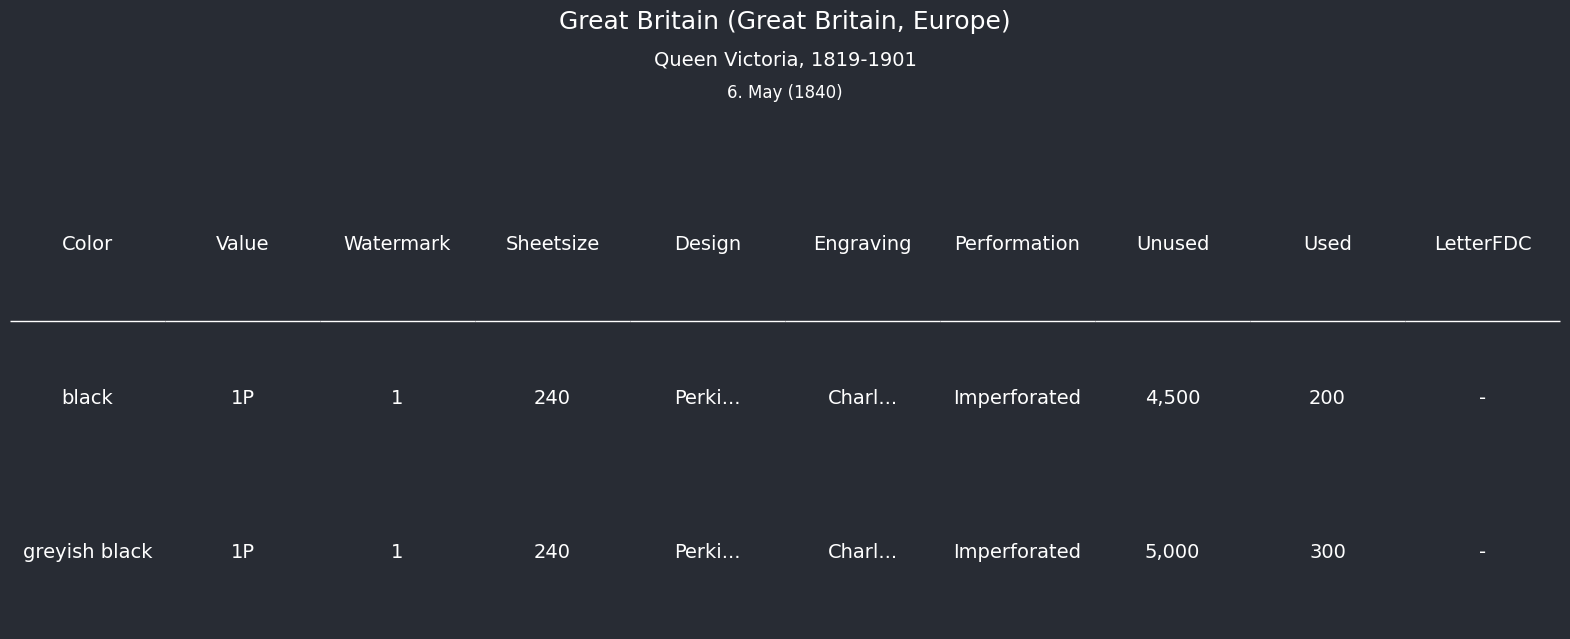

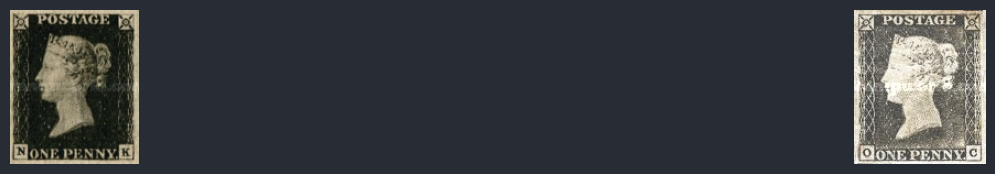

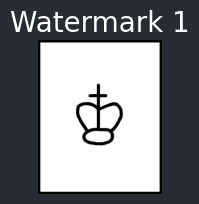

In [245]:
# set seed
# np.random.seed(13)

country, group_id = get_random_group_id()
images = get_images(country, group_id)
entries = get_entries(group_id)

description = get_description(entries)
country = get_country(entries)
continent = get_continent(entries)
parent_countries = get_parent_countries(entries)
date = get_year(entries)
columns = get_columns(entries)

# Make header larger
plt.figure(figsize=(20, 6))

# Make background black
plt.gcf().patch.set_facecolor('#282c34')

# Make text white
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white",
                     'xtick.color': "white",
                     'ytick.color': "white"})

# Add title text with different font sizes
plt.text(0.5, 1, country + ' (' + parent_countries + ", " + continent + ')', fontsize=18, ha='center')
plt.text(0.5, 0.92, description, fontsize=14, ha='center')
plt.text(0.5, 0.85, date, fontsize=12, ha='center')

# Hide axes
plt.axis('off')

# Create the table with increased row spacing
table = plt.table(cellText=columns.values, colLabels=columns.columns, cellLoc='center', loc='center', 
                  cellColours=[['#282c34']*len(columns.columns)]*len(columns), colColours=['#282c34']*len(columns.columns),
                  rowLoc='center', bbox=[0, -0.3, 1, 1])

# Adjust row heights
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)  # Scale the height of the rows

# Customize cell edges
for i, key in enumerate(table.get_celld().keys()):
    cell = table.get_celld()[key]
    if key[0] == 1:  # First row
        cell.set_edgecolor('white')
    else:
        cell.set_edgecolor('#282c34')  # Same color as background to hide

# Show only the line between the first and second row
for j in range(len(columns.columns)):
    table[(1, j)].visible_edges = 'T'

plt.show()

display_images(images)
display_watermark(entries, country)